In [1]:
import cv2 # OpenCV library
import numpy as np # Numpy library for scientific computing
import matplotlib.pyplot as plt # Matplotlib library for plotting
import numpy as np
import math

In [2]:
MAZE_FILE_NAME = "../Maze.png"
ROBOT_FILE_NAME = "../Robot.png"
IMAGE_LADYBUG_FILE_NAME = '../Ladybug_small.png'
MAP_FILE_NAME = "../MapBuilt.txt"

### Display original Map, Robot and Ladybug

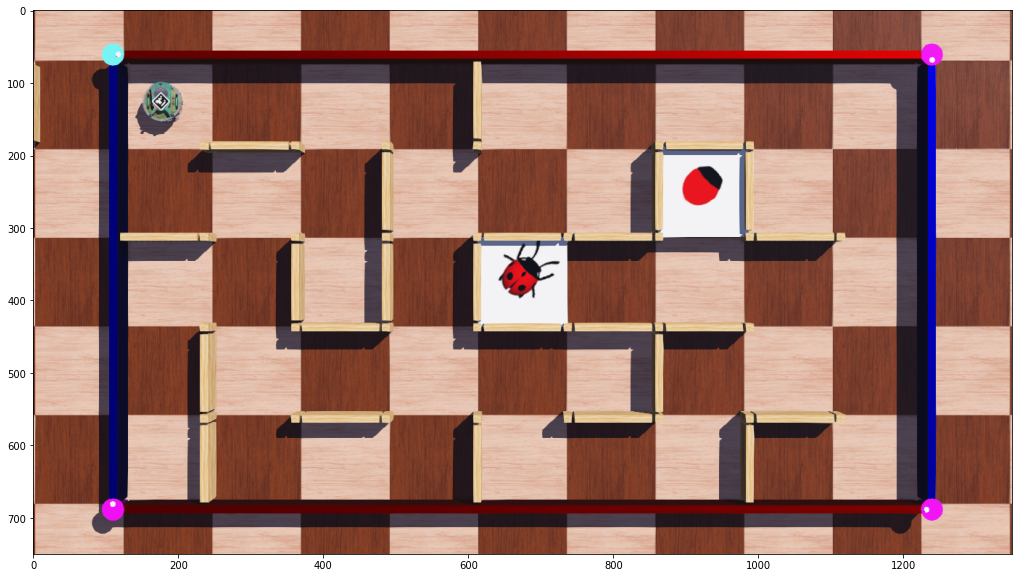

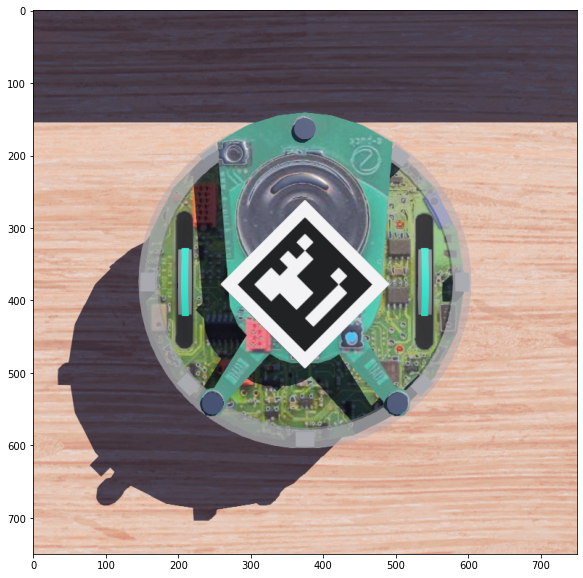

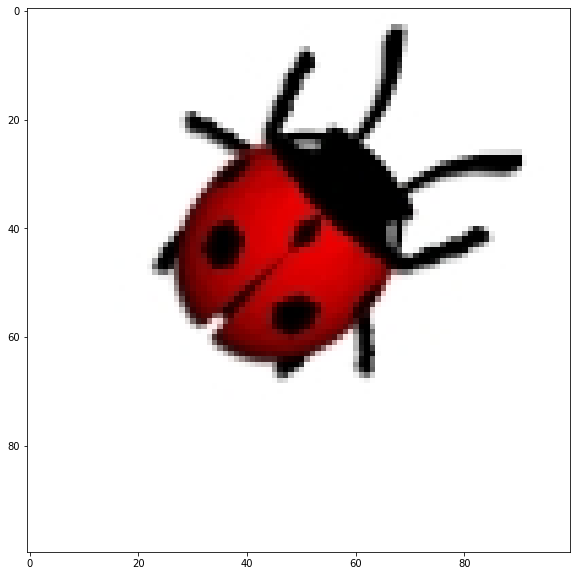

In [3]:
img = cv2.imread(MAZE_FILE_NAME)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV reads an image in the BGR order by default, this function can change the order to RGB
plt.figure(figsize = (18, 10))
plt.imshow(img_rgb)
plt.show()


robot = cv2.imread(ROBOT_FILE_NAME)
robot_rgb = cv2.cvtColor(robot, cv2.COLOR_BGR2RGB) # OpenCV reads an image in the BGR order by default, this function can change the order to RGB
plt.figure(figsize = (18, 10))
plt.imshow(robot_rgb)
plt.show()

ladybug = cv2.imread(IMAGE_LADYBUG_FILE_NAME)
ladybug_rgb = cv2.cvtColor(ladybug, cv2.COLOR_BGR2RGB) # OpenCV reads an image in the BGR order by default, this function can change the order to RGB
plt.figure(figsize = (18, 10))
plt.imshow(ladybug_rgb)
plt.show()

### Functions

In [4]:
minDist = 100
param1 = 100 #500
param2 = 5 #200 #smaller value-> more false circles
minRadius = 1 #10
maxRadius = 30 #20

def rotate(img):
    height, width,colour = img.shape
    pts1 = np.float32([[0,0], [width,0], [0,height], [height,width]])
    pts2 = np.float32([[height,width], [0,height], [width,0], [0,0]])
      
    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(img, matrix, (width, height))
    return img

def identify_corners(img,robot_rgb):
    pink = pink_threshold(img)
    cyan = cyan_threshold(img)
    image = pink + cyan
    
    A = image[0:375, 0:338]
    B = image[0:375, 1012:1350]
    C = image[375:750, 0:338]
    D = image[375:750, 1012:1350]
    corners = [(A,0,0),(B,1012,0),(C,0,375),(D,1012,375)]
    
    img_cpy = img.copy()
    
    coordinates = list()
    flipped = False
    for corner in corners:
        output = corner[0].copy()
        ret, corner_mask = cv2.threshold(corner[0], 0, 255, cv2.THRESH_BINARY)
        corner_mask = cv2.cvtColor(corner_mask, cv2.COLOR_BGR2GRAY)
        kernel = (21, 21)
        closing = cv2.morphologyEx(corner_mask, cv2.MORPH_CLOSE, kernel)
#         closing = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, kernel)
#         closing = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, kernel)
#         closing = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, kernel)
        dilatation_dst = cv2.dilate(closing, (101,101))
        edges = cv2.Canny(dilatation_dst,100,200)
        
        
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
       
        for c in contours:
        # compute the center of the contour
            M = cv2.moments(c)
            if M["m00"] != 0:
                
                x = int(M["m10"] / M["m00"])
                y = int(M["m01"] / M["m00"])


                pixels = np.float32(output.reshape(-1, 3))

                n_colors = 3
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
                flags = cv2.KMEANS_RANDOM_CENTERS

                _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
                _, counts = np.unique(labels, return_counts=True)
                colour = palette[np.where(palette == np.amax(palette))[0]]
                
                colour_patch = np.ones(shape=output.shape, dtype=np.uint8)*np.uint8(colour)
#                 print(output.shape)
#                 print(colour.shape)

                
#                 plt.figure(figsize = (18, 10))
#                 plt.imshow(colour_patch)
#                 plt.show()

                
    
                avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(colour)
              
                
                red,green,blue = colour_patch[y,x]
#                 print(output[y,x])
#                 print(colour_patch[0][0])
                if (len(coordinates)!= 0):
                    if(abs((coordinates[-1][0]+coordinates[-1][1]) -(x+corner[1]+y+corner[2])) < 100):
                        x_new = int((coordinates[-1][0] + x+corner[1]) /2)
                        y_new = int((coordinates[-1][1] + y+corner[2]) /2)
                        coordinates[-1][0] = x_new
                        coordinates[-1][1] = y_new
                        x = x_new - corner[1]
                        y = y_new - corner[2]
                    else:
                        coordinates.append([x+corner[1],y+corner[2]])
                else:
                    coordinates.append([x+corner[1],y+corner[2]])
                if((red > 170 and blue > 170) or (output[y,x][0] > 170 and output[y,x][2] >170)): #Red
#                     cv2.circle(output, (x, y), 7, (255, 0, 0), 4)
#                     cv2.rectangle(output, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1)
                    cv2.circle(img_cpy, (x+corner[1], y+corner[2]), 7, (255 ,0, 0), 4)
                    cv2.rectangle(img_cpy, (x - 2 +corner[1], y - 2+corner[2]), (x + 2+corner[1], y + 2+corner[2]), (0, 128, 255), -1)
#                     coordinates.append([x+corner[1],y+corner[2]])
                elif((red < 240 and blue > 230) or (output[y,x][0] < 240 and output[y,x][2] >230) ): #Green
#                     cv2.circle(output, (x, y), 7, (0, 255, 0), 4)
#                     cv2.rectangle(output, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1)
                    cv2.circle(img_cpy, (x+corner[1], y+corner[2]), 7, (0 ,255, 0), 4)
                    cv2.rectangle(img_cpy, (x - 2 +corner[1], y - 2+corner[2]), (x + 2+corner[1], y + 2+corner[2]), (0, 128, 255), -1)
#                     coordinates.append([x+corner[1],y+corner[2]])
                    if(corner is corners[3]):
                        flipped = True
#                 cv2.drawContours(output, contours, -1, (0,255,0), 3)
#                 fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
#                 ax0.imshow(output)
#                 ax0.set_title('output')
#                 ax0.axis('off')
#                 ax1.imshow(colour_patch)
#                 ax1.set_title('colors')
#                 ax1.axis('off')
#                 plt.show(fig)
#         plt.figure(figsize = (18, 10))
#         plt.imshow(output)
#         plt.show()
               
            
            
    if flipped == True:
        coordinates = coordinates[::-1]
        robot_rgb = rotate(robot_rgb)
        
    return img_cpy,coordinates,robot_rgb

def projective_transform(img,coordinates):
    # Locate points of the documents or object which you want to transform
#     print(coordinates[0])
    pts1 = np.float32([coordinates[0], coordinates[1], coordinates[2], coordinates[3]])
    pts2 = np.float32([[0, 0], [900, 0], [0, 500], [900, 500]])
      
    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img.copy(), matrix, (900, 500))
    return result
def pink_threshold(img):
    img_cpy = img.copy()
    hsv = cv2.cvtColor(img_cpy, cv2.COLOR_RGB2HSV)
    # Threshold of brown in HSV space
    lower = np.array([140,170 ,170])
    upper = np.array([160 ,255 ,255])

    # preparing the mask to overlay
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(img_cpy,img_cpy, mask = mask)
    return result

def cyan_threshold(img):
    img_cpy = img.copy()
    hsv = cv2.cvtColor(img_cpy, cv2.COLOR_RGB2HSV)


    # Threshold of brown in HSV space
    lower = np.array([90, 120, 235])
    upper = np.array([100 ,140 ,255])

    # preparing the mask to overlay
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(img_cpy,img_cpy, mask = mask)
    return result

def red_threshold(img):
    #179 231 233
    
    img_cpy = img.copy()
    hsv = cv2.cvtColor(img_cpy, cv2.COLOR_RGB2HSV)


    # Threshold of brown in HSV space
    lower = np.array([169, 211, 213])
    upper = np.array([189, 251 ,253])

    # preparing the mask to overlay
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(img_cpy,img_cpy, mask = mask)
    return result

def green_threshold(img):
    #179 231 233
    
    img_cpy = img.copy()
    hsv = cv2.cvtColor(img_cpy, cv2.COLOR_RGB2HSV)


    # Threshold of brown in HSV space
    lower = np.array([ 30 , 0, 0])
    upper = np.array([ 85  ,190 ,190])

    # preparing the mask to overlay
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(img_cpy,img_cpy, mask = mask)
    return result

def detect_walls(img):
    img_cpy = img.copy()
    hsv = cv2.cvtColor(img_cpy, cv2.COLOR_RGB2HSV)

#     print(hsv[107,184])
    # Threshold of brown in HSV space
    lower_brown = np.array([14, 79, 222])
    upper_brown = np.array([24, 255, 255])

    # preparing the mask to overlay
    mask = cv2.inRange(hsv, lower_brown, upper_brown)

    # The black region in the mask has the value of 0,
    # so when multiplied with original image removes all non-blue regions
    result = cv2.bitwise_and(img_cpy,img_cpy, mask = mask)
    gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
    kernel = np.ones((9,9),np.uint8)
    close = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    
    result_mask = img_cpy.copy()
    for height in range(img_cpy.shape[0]):
        for width in range(img_cpy.shape[1]):
            if close[height,width] > 0:
                img_cpy[height,width] = [0,0,255]
                result_mask[height,width] = [0,0,255]
            else:
                result_mask[height,width] = [0,0,0]
    return img_cpy,result_mask

def detect_bot(maze,robot):
    minDist = 100
    param1 = 50 #500
    param2 = 10 #200 #smaller value-> more false circles
    minRadius = 10 
    maxRadius = 15 #10
    robot_cpy = robot.copy()
    maze_cpy = maze.copy()
    bot = green_threshold(maze_cpy)
    # Generate an ArUco marker for use
    # Load the predefined dictionary
    dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)

    # Initialize the detector parameters using default values
    parameters =  cv2.aruco.DetectorParameters_create()

    # Detect the markers in the image
    markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(robot_cpy, dictionary, parameters=parameters)

    robot_cpy = cv2.aruco.drawDetectedMarkers(robot_cpy, markerCorners, markerIds)
    markerCorners = np.array(markerCorners,dtype=int)
    
    #Draw the contours around the robot
    ret, bot_mask = cv2.threshold(bot[:, :,2], 200, 255, cv2.THRESH_BINARY)

    walls_thresh = cv2.adaptiveThreshold(bot_mask,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,2)
    coordinates = list()
    ret, bot_mask = cv2.threshold(bot, 0, 255, cv2.THRESH_BINARY)
    bot_mask = cv2.cvtColor(bot_mask, cv2.COLOR_BGR2GRAY)
    kernel = (21, 21)
    closing = cv2.morphologyEx(bot_mask, cv2.MORPH_CLOSE, kernel)
    edges = cv2.Canny(closing,100,200)

#     output = walls.copy()

    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]


    for c in contours:
    # compute the center of the contour
        M = cv2.moments(c)
        if M["m00"] != 0:

            x = int(M["m10"] / M["m00"])
            y = int(M["m01"] / M["m00"])

            if (len(coordinates)!= 0):
                if(abs((coordinates[-1][0]+coordinates[-1][1]) -(x+y)) < 100):
                    new_x = int((coordinates[-1][0] + x) /2)
                    new_y = int((coordinates[-1][1] + y) /2)
                    coordinates[-1][0] = new_x
                    coordinates[-1][1] = new_y
                    continue
            else:
                coordinates.append([x,y])
                
    x = coordinates[-1][0]
    y = coordinates[-1][1]
    cv2.circle(maze_cpy, (x, y), 25, (0, 255, 0), 4)
    if(markerCorners[0][0][0][1] < markerCorners[0][0][1][1] and markerCorners[0][0][0][1] < markerCorners[0][0][3][1]):
    #                 print("North")
        cv2.line(maze_cpy, (x,y),(x-5,y+10), [0,255,0], 3)
        cv2.line(maze_cpy, (x,y),(x+5,y+10), [0,255,0], 3)
        bot_heading = 2
    elif(markerCorners[0][0][0][1] > markerCorners[0][0][1][1] and markerCorners[0][0][0][1] > markerCorners[0][0][3][1]):
    #                 print("South")
        cv2.line(maze_cpy, (x,y),(x-5,y-10), [0,255,0], 3)
        cv2.line(maze_cpy, (x,y),(x+5,y-10), [0,255,0], 3)
        bot_heading = 3
    elif(markerCorners[0][0][0][0] < markerCorners[0][0][1][0] and markerCorners[0][0][0][0] < markerCorners[0][0][3][0]):
    #                 print("West")
        cv2.line(maze_cpy, (x,y),(x+5,y-10), [0,255,0], 3)
        cv2.line(maze_cpy, (x,y),(x+5,y+10), [0,255,0], 3)
        bot_heading = 5
    else:
    #                 print("East")
        cv2.line(maze_cpy, (x,y),(x-5,y-10), [0,255,0], 3)
        cv2.line(maze_cpy, (x,y),(x-5,y+10), [0,255,0], 3)
        bot_heading = 4
    return maze_cpy,(math.floor(x/100),math.floor(y/100)),bot_heading

def detect_goal(img,ladybug):
    ladybug_cpy = ladybug.copy()
    template = cv2.cvtColor(ladybug_cpy, cv2.COLOR_RGB2GRAY)
    template = template[20:70, 20:70]
    # template = cv2.resize(template, (100,100), interpolation = cv2.INTER_AREA)
    w, h = template.shape[::-1]

    # plt.figure(figsize = (18, 10))
    # plt.imshow(template,cmap="gray")
    # plt.show() 

    output_gray = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
    goal = output.copy()
    img = output_gray.copy()
    method = cv2.TM_CCOEFF
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    x = int(top_left[0] + w/2)
    y = int(top_left[1] + h/2)
    cv2.rectangle(goal,top_left, bottom_right, [255,255,255], 10)
    cv2.circle(goal, (x, y), 40, (0, 255, 0), 7)
    cv2.putText(goal,"X", (x-20,y+20), cv2.FONT_HERSHEY_SIMPLEX, 2, [0,255,0],7)

#     fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
#     ax0.imshow(res,cmap ='gray')
#     ax0.set_title('Matching Result'), plt.xticks([]), plt.yticks([])
#     ax0.axis('off')
#     ax1.imshow(goal)
#     ax1.set_title('Detected Point'), plt.xticks([]), plt.yticks([])
#     ax1.axis('off')
#     plt.show(fig)

    if(math.ceil(x/ 100.0)*100.0 -x  < 5):
#         print(x)
#         print(math.ceil(x/ 100.0)*100.0)
        x = math.ceil(x/100)
#         print(x)
    else:
        x = math.floor(x/100)
    if(math.ceil(y/100.0)*100.0 -y  < 5):
#         print(y)
#         print(math.ceil(y/100.0)*100.0)
        y = math.ceil(y/100)
#         print(y)
    else:
        y = math.floor(y/100)
    return goal,(x,y)


def print_map(bot_coords,bot_heading,goal_coords,mask):
    maze = np.zeros((11,19))
    maze[0] = 1
    maze[10] = 1
    maze[:,0] = 1
    maze[:,18] = 1
    maze[bot_coords[1]*2 +1,bot_coords[0]*2 +1] = bot_heading
    maze[goal_coords[1]*2 +1,goal_coords[0]*2 +1] = 6
    for height in range(int((maze.shape[0])/2)):
        for width in range(int((maze.shape[1])/2)):
    #         print(height)
    #         print(width)

            x = height*100
            if(x <= 0):
                x = 10
            if(x >= mask.shape[0]):
                x = mask.shape[0]-10
            y = 50 + width*100 
            if(y >= mask.shape[1]):
                y = mask.shape[1] -10
            wall_coords = (x,y)
    #         print(wall_coords)
        #     wall_coords = [100,150]
            mask_cpy = mask.copy()

            area = mask_cpy[wall_coords[0]-10:wall_coords[0]+10, wall_coords[1]-10:wall_coords[1]+10]
            top_left = wall_coords[1]-10,wall_coords[0]-10
            bottom_right =wall_coords[1]+10,wall_coords[0]+10
            # print(top_left)
            # print(bottom_right)


            pixels = np.float32(area.reshape(-1, 3))

            n_colors = 3
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
            flags = cv2.KMEANS_RANDOM_CENTERS

            _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
            _, counts = np.unique(labels, return_counts=True)
            colour = palette[np.where(palette == np.amax(palette))[0]]


            colour_patch = np.ones(shape=area.shape, dtype=np.uint8)*np.uint8(colour[0])

            cv2.rectangle(mask_cpy,top_left, bottom_right, [255,255,255], 3)


    #         print(colour_patch[0,0])
            red,green,blue = colour_patch[0,0]
            if (blue > 250):
                maze[height*2][width*2+1] = 1
    #             print("Wall")
    #             print(width)
    #             print(height)
    #             fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,10))
    #             ax0.imshow(mask_cpy)
    #             ax0.set_title('mask_cpy')
    #             ax0.axis('off')
    #             ax1.imshow(area)
    #             ax1.set_title('area')
    #             ax1.axis('off')
    #             plt.show(fig)


    #             print(maze)


    for height in range(int((maze.shape[0])/2)):
        for width in range(int((maze.shape[1])/2)):
    #         print(height)
    #         print(width)

            x = 50 + height*100
            if(x <= 0):
                x = 10
            if(x >= mask.shape[0]):
                x = mask.shape[0]-10
            y = width*100 
            if(y <= 0):
                y = 10
            if(y >= mask.shape[1]):
                y = mask.shape[1] -10
            wall_coords = (x,y)
    #         print(wall_coords)
        #     wall_coords = [100,150]
            mask_cpy = mask.copy()

            area = mask_cpy[wall_coords[0]-10:wall_coords[0]+10, wall_coords[1]-10:wall_coords[1]+10]
            top_left = wall_coords[1]-10,wall_coords[0]-10
            bottom_right =wall_coords[1]+10,wall_coords[0]+10
            # print(top_left)
            # print(bottom_right)


            pixels = np.float32(area.reshape(-1, 3))

            n_colors = 3
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
            flags = cv2.KMEANS_RANDOM_CENTERS

            _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
            _, counts = np.unique(labels, return_counts=True)
            colour = palette[np.where(palette == np.amax(palette))[0]]


            colour_patch = np.ones(shape=area.shape, dtype=np.uint8)*np.uint8(colour[0])

            cv2.rectangle(mask_cpy,top_left, bottom_right, [255,255,255], 3)


    #         print(colour_patch[0,0])
            red,green,blue = colour_patch[0,0]
            if (blue > 250):
                maze[height*2+1][width*2] = 1
    #             print("Wall")
    #             print(width)
    #             print(height)

    #             fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,10))
    #             ax0.imshow(mask_cpy)
    #             ax0.set_title('mask_cpy')
    #             ax0.axis('off')
    #             ax1.imshow(area)
    #             ax1.set_title('area')
    #             ax1.axis('off')
    #             plt.show(fig)

    #             print(maze)


#North = 2
#South = 3
#East = 4
#West = 5
    ret = ""
    for height in range(int((maze.shape[0]))):
        for width in range(int((maze.shape[1]))):
            if(height%2):
                if(width%2 == 0):
    #                 print(width)
                    if(maze[height][width] == 1):
    #                     print("|", end="")
                        ret = ret + "|"
                    else:
    #                     print(" ", end="")
                        ret = ret + " "
                else:
                    if(maze[height][width] == 2):
    #                     print(" ^ ", end="")
                        ret = ret + " ^ "
                    elif(maze[height][width] == 3):
    #                     print(" v ", end="")
                        ret = ret + " v "
                    elif(maze[height][width] == 4):
    #                     print(" > ", end="")
                        ret = ret + " > "
                    elif(maze[height][width] == 5):
    #                     print(" < ", end="")
                        ret = ret + " <"
                    elif(maze[height][width] == 6):
    #                     print(" x ", end="")
                        ret = ret + " x "
                    else:
    #                     print("   ", end="")
                        ret = ret + "   "
            else:

                if(width%2==0):
    #                 print(" ", end="")
                    ret = ret + " "
                else:
                    if(maze[height][width] == 1):
    #                     print("...", end="")
                        ret = ret + "..."
                    else:
    #                     print("   ", end="")
                        ret = ret + "   "

    #     print("\n")
        ret = ret + "\n"
    return ret

In [13]:
img_cpy,coordinates,robot_rgb = identify_corners(img_rgb,robot_rgb)
transformed_image = projective_transform(img_rgb,coordinates)
walls,mask = detect_walls(transformed_image)
output,bot_coords,bot_heading = detect_bot(walls,robot_rgb)
goal,goal_coords = detect_goal(output,ladybug_rgb)
ret = print_map(bot_coords,bot_heading,goal_coords,mask)
with open(MAP_FILE_NAME, 'w') as f:
    f.write(ret)
f.close()
print(ret)

 ... ... ... ... ... ... ... ... ... 
| v             |                   |
     ...                 ...         
|           |           |   |       |
 ...             ... ...     ...     
|       |   |   | x                 |
         ...     ... ... ...         
|   |                   |           |
         ...         ...     ...     
|   |           |           |       |
 ... ... ... ... ... ... ... ... ... 

